In [1]:
# %pip install opensimplex

In [2]:
#imports
import numpy as np
import matplotlib.pyplot as plt
from opensimplex import OpenSimplex
import cv2
import random
import bisect


### A1

- To represent both the images - those generated from the microscope and those generated by the dye sensor, I used a variation of RLE (Run length encoding)
- Each image is represented with a datastructure that looks like: 


IMAGE_REPRESENTATION: 
- **bounding_box_coordinates:** ((x1,y1), (x2,y2))  These coordinates represent the pixel locations of the top left and bottom right corners of the bounding box. The bounding box is the smallest rectangle that contains every parasite/dye pixel.
- **starting_value:** This contains the pixel value of the top left corner of the bounding box. A pixel can either represent a parasite(255), dye(100), or 0
- **Run_length_encoding_list:** - This is a list of containing the lengths of consecutive runs of pixels. Alternative to the conventional RLE algorithms, the list contains only integers representing run lengths. The value present in the lengths is not stored. Using starting_value and the fact that the value between runs alternate between 0 and 255/100, the value present in each run can easily be computed and storage is therefore reduced
- **pixel_count:** - This contains the number of pixels in the image that are non-zero (a parasite/dye). This is used to calculate the percentage of dye dissociation to detect cancer. To reduce storage, I could remove this from the image representation and calculate it during run time. However, it would lead to a few more functions. Given more time, I would remove this from the datastructure

RATIONALE:
- Since the parasite and the dye captured in these images are a single blob and is not dispersed over the whole image, a bounding box can reduce storage tremendously by only storing the important pixels of the image. I leveraged the fact that in most images, only around 25% of the pixels are necessary for our objective and they are clustered into one blob, the necessary information can be contained in a smaller box rather than the whole image.
- RLE seems like an optimum approach for this task as the parasite/dye exist as a blob, therefore, the run lengths are high but the number of runs are low. This is because there are large stretches of the same color pixels together (not sparse).
- Leveraging the fact that, there are only 2 possible values of pixels for each image, the RLE is further reduced by only storing the run lengths and no the run values. A starting value is enough to compute the run values during run time

WORST CASE STORAGE: (assuming integer takes 4 bytes)
- Bounding Box coordinates: This is 2 tuples of integers, therefore 4 integers. Max storage: 16 bytes
- Starting Value: 1 integer - 4 bytes
- RLE - Worst case is when the image has alternating 0 and non-zero values. It would take (width x height/2) x 4 bytes. However, the task mentions a single blob, so this is not the case
- Pixel count is an integer that takes 4 bytes


### A2

GENERATING MICROSCOPE IMAGES:
- My approach is to mimic the shape of microbes by generating and overlayig ellipses with random axis lengths and random rotations. Additionally, I perturbed the center of the ellipses (with the constraint that there is no white space between ellipses). This creates images of a single blob that has funky elliptical shapes that look like microbes. This also makes sure that there is no emptyness inside the blob and it is a solid structure. My algorithm continues to generate ellipses and growing the parasite until it acquires more than 25% of the image area. 

Below is a demo of my approach, with smaller scale images(1000px x 1000px). I have generated 5 images with my approach. Note that the pixels with 0 (black) are background and 255 (white) is the parasite. 

Area of parasite:  0.265
Area of parasite:  0.273
Area of parasite:  0.251
Area of parasite:  0.250
Area of parasite:  0.263


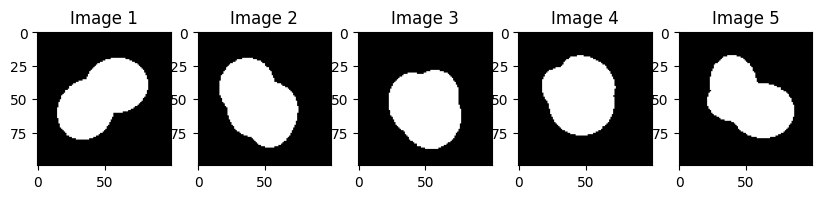

In [3]:
def generate_microscope_image(width, height):
    center = (width // 2, height // 2)
    image_area = width * height

    target_black_area = 0.25 * image_area
    total_black_area = 0
    
    composite_image = np.zeros((height, width), dtype=np.uint8)
    total_black_area = np.count_nonzero(composite_image == 255)
    count = 0
    while total_black_area < target_black_area and count<10:
        count += 1
        # Random parameters for ellipse
        axis_x = np.random.randint(min(width, height) // 6, min(width, height) // 4)
        axis_y = np.random.randint(min(width, height) // 6, min(width, height) // 4)
        angle = np.random.randint(0, 180)  # Random angle of rotation
        
        # Perturb center coordinates with noise
        noise_x = np.random.randint(-min(width, height) // 12, min(width, height) // 7)  # Random noise in x-coordinate (-5 to 5)
        noise_y = np.random.randint(-min(width, height) // 12, min(width, height) // 7)  # Random noise in y-coordinate (-5 to 5)
        perturbed_center = (center[0] + noise_x, center[1] + noise_y)
        
        
        shape = np.zeros((height, width), dtype=np.uint8)
        cv2.ellipse(shape, perturbed_center, (axis_x, axis_y), angle, 0, 360, 255, -1)
        
        # Add distorted shape to list
        composite_image = np.maximum(composite_image, shape)
        total_black_area = np.count_nonzero(composite_image == 255)
        
    
        
    print("Area of parasite: ", "{:.3f}".format(total_black_area/image_area))
    return composite_image

# Parameters
num_images = 5
width, height = 100, 100

# Generate multiple microscope images
sample_microscope_images = []
for _ in range(num_images):
    sample_microscope_images.append(generate_microscope_image(width, height))

# Plot results
plt.figure(figsize=(10, 5))
for i, image in enumerate(sample_microscope_images):
    plt.subplot(1, num_images, i+1)
    plt.imshow(image, cmap='gray', vmin=0, vmax=255)  # Ensure proper display of black (0) and white (255)
    plt.title(f'Image {i+1}')
   


While, I could generate such images for images of size (100,000px x 100,000px), it takes quite a while for the compute that I have. Therefore I used the repeat function to enlarge the above images to the desired size. It serves the purpose of simulating the parasite. The only drawback is that is quite pixelated and not as smooth. I also verified that the area of the parasite in the image is proportionally consistent after enlargement

In [4]:
#Enlarging images
enlarged_microscope_images = []
for image in sample_microscope_images:
    enlarged_image = np.repeat(np.repeat(image, 100, axis=0), 100, axis=1)
    enlarged_microscope_images.append(enlarged_image)
    

enlarged_microscope_images[0].shape

(10000, 10000)

In [5]:
# 
# first_sample_image = sample_microscope_images[0]
# enlarged_image = np.repeat(np.repeat(first_sample_image, 100, axis=0), 100, axis=1)
# enlarged_image.shape

Text(0.5, 1.0, 'Image')

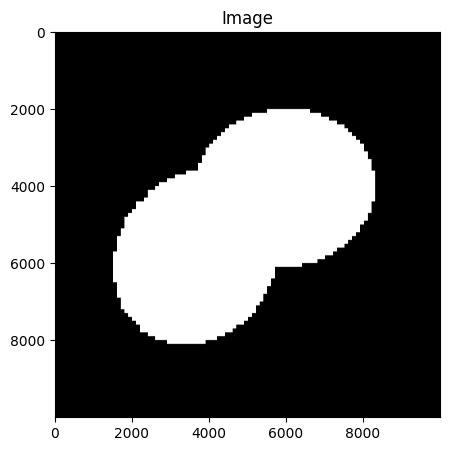

In [6]:
#Plot results - Takes quite a while to plot it. Therefore I commented it
plt.figure(figsize=(10, 5))
plt.imshow(enlarged_microscope_images[0], cmap='gray', vmin=0, vmax=255)  
plt.title(f'Image')

GENERATING DYE SENSOR IMAGES:
To mimic the dye dissipation, I used the following approach:
- Find a point on the parasite, where the die is first injected. This is randomly selected and simulates the microbiologist finding a point of injection on the parasite. This is represented as point_of_injection
- To simulate the dye flowing through blood vessels, the algorithm finds neighbors to the point of injection and randomly selects one to dye. This is done iteratively to simulate the flow of die in random directions (like dye flowing through blood vessels). (function: random_update())
- Additionally, to simulate the flow of dye to the tributaries of blood vessels, after certain time steps, the algorithm grows the dyed portion by 1 pixel on every pixel on the circumfrence. This simulates the flow of liquid through an organism. (function: grow())
- This ensures that the dye can spill over from the parasite to the the background.
- The images are generated for a certain threshold which controls the percentage of parasite that is dyed. For cancerous parasites, this threshold is 0.15. This means that 15% of the parasite is dyed. According to the task if more that 10% of the parasite is dyed, it has cancer.

In [7]:
class DyedImage:
    def __init__(self, image, size, threshold=0.15):
        self.image = image
        self.size = size
        self.dyed_pixels = set()
        self.outer_pixels = set()
        self.microbe_dyed_pixel_count = 0
        self.count = 0
        self.microbe_area = np.count_nonzero(image == 255)
        self.point_of_injection = self.find_point_of_injection()
        self.threshold = threshold
        #self.point_of_injection = (10,10)
        #self.dyed_pixels.add((10,10))
    
    
    def find_point_of_injection(self):
        injection_val = 0
        while True:
            injection_x = np.random.randint(self.size // 3, 2*self.size// 3)
            injection_y = np.random.randint(self.size //3, 2*self.size // 3)
            injection_val = self.image[injection_x][injection_y]
            if injection_val == 255:
                self.microbe_dyed_pixel_count += 1
                self.dyed_pixels.add(((injection_x, injection_y)))
                self.outer_pixels.add(((injection_x, injection_y)))
                return (injection_x, injection_y)
    
    def random_update(self):
        point = random.choice(list(self.dyed_pixels))
        #right, left, up, down
        neighbors = [(point[0]+1, point[1]), (point[0]-1, point[1]), (point[0], point[1]-1), (point[0], point[1]+1)]
        #print("Neigbors: ", neighbors)
        neighbors = [(x, y) for x, y in neighbors if 0 <= x < self.size and 0 <= y < self.size]
        #print("Neigbors: ", neighbors)
        if len(neighbors) == 0:
            #print("No neighbors")
            return
    
        
        valid_neighbors = [neighbor for neighbor in neighbors if self.image[neighbor] == 255]
        
        selected_neighbor = random.choice(neighbors)
        if selected_neighbor in valid_neighbors and selected_neighbor not in self.dyed_pixels:
            self.microbe_dyed_pixel_count += 1

        self.dyed_pixels.add(selected_neighbor)
        self.outer_pixels.add(selected_neighbor)
        
    def grow(self):
        grow_pixels = list(self.outer_pixels)
        self.outer_pixels = set()
        for pixel in grow_pixels:
            neighbors = [(pixel[0]+1, pixel[1]), (pixel[0]-1, pixel[1]), (pixel[0], pixel[1]-1), (pixel[0], pixel[1]+1)]
            neighbors = [(x, y) for x, y in neighbors if 0 <= x < self.size and 0 <= y < self.size]
            
            valid_neighbors = [neighbor for neighbor in neighbors if self.image[neighbor] == 255]
            for neighbor in neighbors:
                if neighbor in valid_neighbors and neighbor not in self.dyed_pixels:
                    self.microbe_dyed_pixel_count += 1
                self.dyed_pixels.add(neighbor)
                self.outer_pixels.add(neighbor)
    
    def compute_dye_dissipation(self):
        while self.microbe_dyed_pixel_count < self.threshold*self.microbe_area:
            self.random_update()
            self.count+=1
            if self.count%500 == 0:
                self.grow()
            
            #if self.microbe_dyed_pixel_count%1000==0:
            
        print("Area of parasite that is dyed:", "{:.3f}".format(self.microbe_dyed_pixel_count/self.microbe_area))
        # print("microbe pixel count", self.microbe_dyed_pixel_count)
        # print("dyed piels", len(list(self.dyed_pixels)))
    
    def create_array_with_dyed_pixels(self):
        # Create an array filled with zeros
        array = np.zeros((self.size, self.size), dtype=int)
        
        # Assign value 100 to pixels in dyed_pixels
        for pixel in self.dyed_pixels:
            array[pixel] = 100
        
        return array

    def plot_overlap(self):
        # Create a new figure
        plt.figure(figsize=(8, 8))
        
        # Plot the first array (dyed pixels)
        plt.imshow(self.create_array_with_dyed_pixels(), cmap='gray', vmin=0, vmax=255)
        
        # Plot the second array (completely different shape)
        plt.imshow(self.image, cmap='gray', alpha=0.5, vmin=0, vmax=255)  # Use alpha to make it semi-transparent
        
        # Add color bar
        plt.colorbar()
        
        # Show the plot
        plt.show()
        
    def plot_side_by_side(self):
        # Create a new figure with two subplots in one row and two columns
        fig, axs = plt.subplots(1, 2, figsize=(12, 6))
        
        # Plot the first array (dyed pixels) in the first subplot
        axs[0].imshow(self.create_array_with_dyed_pixels(), cmap='gray', vmin=0, vmax=255)
        axs[0].set_title('Dyed Pixels')  # Set title for the first subplot
        
        # Plot the second array (completely different shape) in the second subplot
        axs[1].imshow(self.image, cmap='gray', vmin=0, vmax=255)
        axs[1].set_title('Microbe')  # Set title for the second subplot
        
        # Show the plot
        plt.show()
        

image  0
Area of parasite that is dyed: 0.173
image  1
Area of parasite that is dyed: 0.130
image  2
Area of parasite that is dyed: 0.030
image  3
Area of parasite that is dyed: 0.064
image  4
Area of parasite that is dyed: 0.010


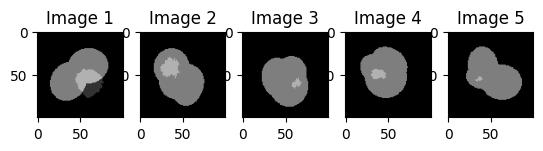

In [8]:
num_images = 5
sample_dye_images = []
thresholds = [0.15,0.13,0.03,0.05,0.01]
for i, image in enumerate(sample_microscope_images):
    print("image ", i)
    di = DyedImage(image, 100, thresholds[i])
    di.compute_dye_dissipation()
    dye_image = di.create_array_with_dyed_pixels()
    sample_dye_images.append(dye_image)
    plt.subplot(1, num_images, i+1)
    plt.imshow(dye_image, cmap='gray', vmin=0, vmax=255)
    plt.imshow(image, cmap='gray', alpha=0.5, vmin=0, vmax=255)  # Set alpha to control transparency
    plt.title(f'Image {i+1}')


In [9]:
#Enlarging
enlarged_dye_images = []
for image in sample_dye_images:
    enlarged_dyed_image = np.repeat(np.repeat(image, 100, axis=0), 100, axis=1)
    enlarged_dye_images.append(enlarged_dyed_image)
    
enlarged_dye_images[0].shape

(10000, 10000)

Text(0.5, 1.0, 'Image')

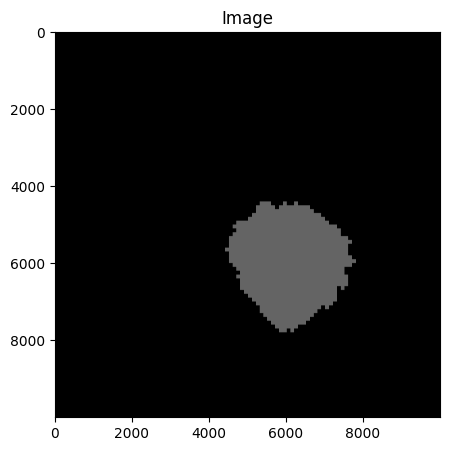

In [10]:
#Plot - Takes long to run and sometimes kernel crashes
plt.figure(figsize=(10, 5))
plt.imshow(enlarged_dye_images[0], cmap='gray', vmin=0, vmax=255)  # Ensure proper display of black (0) and white (255)
plt.title(f'Image')

### Storing and compressing
In the below section, I will use the datastructure I created to store these images. 

In [11]:
class ImageCompressor:
    def __init__(self):
        #self.image = None
        self.bounding_box = None
        self.start_value = None
        self.rle_encoding = None
        self.pixel_count = None
        pass
    
    def compute_bounding_box(self, image, val):
        rows, cols = image.shape

        top_row = next((i for i in range(rows) if val in image[i]), None)
        if top_row is None:
            return None  

        bottom_row = next((i for i in range(rows - 1, -1, -1) if val in image[i]), None)
        if bottom_row is None:
            return None  

        left_col = next((j for j in range(cols) if val in image[:, j]), None)
        if left_col is None:
            return None 

        right_col = next((j for j in range(cols - 1, -1, -1) if val in image[:, j]), None)
        if right_col is None:
            return None  

        self.bounding_box = ((top_row, left_col), (bottom_row, right_col))
        return ((top_row, left_col), (bottom_row, right_col))
    
    def compute_rle_encoding(self, image, val):
        if self.bounding_box is None:
            return None, None  # No bounding box, return None

        top_left, bottom_right = self.bounding_box
        min_row, min_col = top_left
        max_row, max_col = bottom_right

        rle_encoding = []
        start_value = image[min_row][min_col]  # First value in the bounding box
        current_color = start_value
        run_length = 0
        pixel_count = 0  # Initialize count of pixels with the specified value
        for row in range(min_row, max_row + 1):
            for col in range(min_col, max_col + 1):
                if image[row][col] == current_color:
                    run_length += 1
                    if current_color == val:  # Increment pixel count if value matches val
                        pixel_count += 1
                else:
                    rle_encoding.append(run_length)
                    current_color = image[row][col]
                    run_length = 1

        rle_encoding.append(run_length)
        self.start_value = start_value
        self.rle_encoding = rle_encoding
        self.pixel_count = pixel_count  # Store pixel count
        return start_value, rle_encoding, pixel_count

    def compress(self, image, val):
        self.compute_bounding_box(image, val)
        self.compute_rle_encoding(image, val)
        
        return (self.bounding_box, self.start_value, self.rle_encoding, self.pixel_count)


In [12]:
ic = ImageCompressor()
compressed_microscope_images = []
for image in enlarged_microscope_images:
    compressed_microscope_image = ic.compress(image, 255)
    compressed_microscope_images.append(compressed_microscope_image)


In [13]:

compressed_dye_images = []
for image in enlarged_dye_images:
    compressed_dye_image = ic.compress(image, 100)
    compressed_dye_images.append(compressed_dye_image)


In [14]:
import sys
print("size of original image: ", sys.getsizeof(enlarged_microscope_images[0]), "bits")
print("size of compressed image: ", sys.getsizeof(compressed_microscope_images[0][0]) + sys.getsizeof(compressed_microscope_images[0][1]) + sys.getsizeof(compressed_microscope_images[0][2]) + sys.getsizeof(compressed_microscope_images[0][3]), " bits")


size of original image:  100000128 bits
size of compressed image:  108005  bits


### A3

Below is a cancer detector class
- It calculates the smallest overlapping box between the microscope image and the dye sensor image. This way, we can run the overlap detection algorithm on just this box and save computation time tremendously
- The overlap detection algorithm computes the current run length of each image and using each images starting_value, it computes the value of the pixel in the current run length. If both the pixels are non-zero, then there is an overlap( dye on the parasite). By counting the number of these pixels, the algorihtm detects if the parasite has cancer

In [15]:
class cancerDetector:
    def __init__(self):
        self.microscope_image = None
        self.dye_image = None
        self.overlapped_box = None
        self.curr_rl_microscope=0
        self.curr_rl_dye=0
        self.microscope_cum_re = None
        self.dye_cum_re = None
    
    def add_images(self, microscope_image, dye_image):
        self.microscope_image = microscope_image
        self.dye_image = dye_image
        self.microscope_cum_re = [sum(self.microscope_image[2][:i+1]) for i in range(len(self.microscope_image[2]))]
        self.dye_cum_re = [sum(self.dye_image[2][:i+1]) for i in range(len(self.dye_image[2]))]
    
    def compute_overlapped_box(self):
        if self.microscope_image is None or self.dye_image is None:
            raise ValueError("Both microscope and dye images must be provided.")

        # Extract bounding boxes
        microscope_bbox = self.microscope_image[0]
        dye_bbox = self.dye_image[0]

        # Calculate intersection of bounding boxes
        min_row = max(microscope_bbox[0][0], dye_bbox[0][0])
        min_col = max(microscope_bbox[0][1], dye_bbox[0][1])
        max_row = min(microscope_bbox[1][0], dye_bbox[1][0])
        max_col = min(microscope_bbox[1][1], dye_bbox[1][1])

        #print(((min_row, min_col), (max_row, max_col)))
        # Check if intersection is valid
        if min_row <= max_row and min_col <= max_col:
            overlapped_box = ((min_row, min_col), (max_row, max_col))
            self.overlapped_box = overlapped_box
            self.curr_rl_microscope = self.compute_run_distance_to_intersection(self.microscope_image[0][0], self.microscope_image[0][1][1] - self.microscope_image[0][0][1]+1, self.overlapped_box[0])
            self.curr_rl_dye = self.compute_run_distance_to_intersection(self.dye_image[0][0], self.dye_image[0][1][1] - self.dye_image[0][0][1]+1, self.overlapped_box[0])
            
            return overlapped_box
        else:
            return None
    

    def compute_run_distance_to_intersection(self, starting_point, width, start_intersection_point):
    #start_intersection_point = self.overlapped_box[0]
    #start_intersection_point = (0,0)
        
        #print("computing distance between:", starting_point, start_intersection_point)
        if start_intersection_point[0] == starting_point[0]:#meaning same row
            distance = start_intersection_point[1]-starting_point[1]+1
            return distance
        distance = width - starting_point[1] 
        distance += ((start_intersection_point[0]-starting_point[0]-1)*width) + (start_intersection_point[1]+1)
        #print(distance)
        return distance
    
    def compute_overlap(self):
        temp_array = []
        ((min_row, min_col), (max_row, max_col)) = self.overlapped_box
        run_index_mic = bisect.bisect_left(self.microscope_cum_re, self.curr_rl_microscope)
        run_index_dye = bisect.bisect_left(self.dye_cum_re, self.curr_rl_dye)
        curr_val_mic = self.microscope_image[1] if run_index_mic%2==0 else ( 255  if self.microscope_image[1] == 0 else 0)
        curr_val_dye = self.dye_image[1] if run_index_dye%2==0 else ( 255  if self.dye_image[1] == 0 else 0)
        

        
        counter = 0
        overlapping_pixels = 0
        prev_row = min_row
        for row in range(min_row, max_row + 1):
            if row == min_row:
                self.curr_rl_microscope = self.compute_run_distance_to_intersection(self.microscope_image[0][0],self.microscope_image[0][1][1] - self.microscope_image[0][0][1]+1, (min_row, min_col))
                self.curr_rl_dye = self.compute_run_distance_to_intersection(self.dye_image[0][0],self.dye_image[0][1][1] - self.dye_image[0][0][1]+1, (min_row,min_col))
            else:
                self.curr_rl_microscope += self.compute_run_distance_to_intersection((prev_row,max_col),self.microscope_image[0][1][1] - self.microscope_image[0][0][1]+1, (row,min_col))
                self.curr_rl_dye += self.compute_run_distance_to_intersection((prev_row,max_col),self.dye_image[0][1][1] - self.dye_image[0][0][1]+1, (row,min_col))
            run_index_mic = bisect.bisect_left(self.microscope_cum_re, self.curr_rl_microscope)
            run_index_dye = bisect.bisect_left(self.dye_cum_re, self.curr_rl_dye)
            curr_val_mic = self.microscope_image[1] if run_index_mic%2==0 else ( 255  if self.microscope_image[1] == 0 else 0)
            curr_val_dye = self.dye_image[1] if run_index_dye%2==0 else ( 100  if self.dye_image[1] == 0 else 0)
        
            for col in range(min_col, max_col + 1):
                counter +=1
                if curr_val_mic != 0 and curr_val_dye!=0:
                    #print("overlap exists")
                    overlapping_pixels +=1
                else:
                    if len(temp_array) <= 10:
                        temp_array.append((row,col))
                self.curr_rl_microscope +=1
                self.curr_rl_dye +=1
                if self.curr_rl_microscope > self.microscope_cum_re[run_index_mic]:
                    run_index_mic +=1
                    curr_val_mic ^= 255 #flip between 0 and 255
                    
                if self.curr_rl_dye > self.dye_cum_re[run_index_dye]:
                    run_index_dye +=1
                    curr_val_dye ^= 100 #flip between 0 and 255
            
            prev_row = row
            self.curr_rl_microscope -=2
            self.curr_rl_dye -=2
            
        #print("counter:",counter)
        #print("temp array:", temp_array)
        return overlapping_pixels
    
    
    def hasCancer(self):
        self.compute_overlapped_box()
        #print("computing overlap", self.overlapped_box)
        #overlapping_pixels = self.test_overlap(enlarged_image, enlarged_dyed_image)
        overlapping_pixels = self.compute_overlap()
        print("Percentage of dye coverage on parasite:", "{:.3f}".format(overlapping_pixels/self.microscope_image[3]))
        if overlapping_pixels/self.microscope_image[3] > 0.1:
            return True
        
        return False
    

In [16]:
detector = cancerDetector()
for i in range(5):
    detector.add_images(compressed_microscope_images[i], compressed_dye_images[i])
    if detector.hasCancer():
        print("Cancer detected")
    else:
        print("No cancer")

Percentage of dye coverage on parasite: 0.173
Cancer detected
Percentage of dye coverage on parasite: 0.130
Cancer detected
Percentage of dye coverage on parasite: 0.030
No cancer
Percentage of dye coverage on parasite: 0.064
No cancer
Percentage of dye coverage on parasite: 0.010
No cancer


### A4

Leveraging the fact that my datastructure contains the pixel counts, I can speed up the algorithm as follows:
- If the proportion of pixel count in the dye compared to the parasite is less that 10%, the cancerDetection algorithm does not have to run. It is evident that the organism will not have cancer. It is not required to check overlap etc. 
- Another modification to speed it up, is if the threshold is reached in the overlapping algorithm i.e if more than 10% of the parasite is dyed, then the algorithm terminates with Cancer detected rather than computing the accurate propotion of dye in the parasite

Another factor that could improve the speed of the algorithm is to leverage the run lengths to skip through pixels. Rather than iterating through the pixels, the run length encoding provides information of the number of consecutive pixels that have the same value. Therefore by tweaking the logic, one could skip to the next pixel where the value has changed rather than going through all pixels in the overlapping box. Due to the time constraint, I did not implement this

In [17]:
class cancerDetectorFast:
    def __init__(self):
        self.microscope_image = None
        self.dye_image = None
        self.overlapped_box = None
        self.curr_rl_microscope=0
        self.curr_rl_dye=0
        self.microscope_cum_re = None
        self.dye_cum_re = None
    
    def add_images(self, microscope_image, dye_image):
        self.microscope_image = microscope_image
        self.dye_image = dye_image
        self.microscope_cum_re = [sum(self.microscope_image[2][:i+1]) for i in range(len(self.microscope_image[2]))]
        self.dye_cum_re = [sum(self.dye_image[2][:i+1]) for i in range(len(self.dye_image[2]))]
    
    def compute_overlapped_box(self):
        if self.microscope_image is None or self.dye_image is None:
            raise ValueError("Both microscope and dye images must be provided.")

        # Extract bounding boxes
        microscope_bbox = self.microscope_image[0]
        dye_bbox = self.dye_image[0]

        # Calculate intersection of bounding boxes
        min_row = max(microscope_bbox[0][0], dye_bbox[0][0])
        min_col = max(microscope_bbox[0][1], dye_bbox[0][1])
        max_row = min(microscope_bbox[1][0], dye_bbox[1][0])
        max_col = min(microscope_bbox[1][1], dye_bbox[1][1])

        #print(((min_row, min_col), (max_row, max_col)))
        # Check if intersection is valid
        if min_row <= max_row and min_col <= max_col:
            overlapped_box = ((min_row, min_col), (max_row, max_col))
            self.overlapped_box = overlapped_box
            self.curr_rl_microscope = self.compute_run_distance_to_intersection(self.microscope_image[0][0], self.microscope_image[0][1][1] - self.microscope_image[0][0][1]+1, self.overlapped_box[0])
            self.curr_rl_dye = self.compute_run_distance_to_intersection(self.dye_image[0][0], self.dye_image[0][1][1] - self.dye_image[0][0][1]+1, self.overlapped_box[0])
            
            return overlapped_box
        else:
            return None
    

    def compute_run_distance_to_intersection(self, starting_point, width, start_intersection_point):
    #start_intersection_point = self.overlapped_box[0]
    #start_intersection_point = (0,0)
        
        #print("computing distance between:", starting_point, start_intersection_point)
        if start_intersection_point[0] == starting_point[0]:#meaning same row
            distance = start_intersection_point[1]-starting_point[1]+1
            return distance
        distance = width - starting_point[1] 
        distance += ((start_intersection_point[0]-starting_point[0]-1)*width) + (start_intersection_point[1]+1)
        #print(distance)
        return distance
    
    def compute_overlap(self):
        temp_array = []
        ((min_row, min_col), (max_row, max_col)) = self.overlapped_box
        run_index_mic = bisect.bisect_left(self.microscope_cum_re, self.curr_rl_microscope)
        run_index_dye = bisect.bisect_left(self.dye_cum_re, self.curr_rl_dye)
        curr_val_mic = self.microscope_image[1] if run_index_mic%2==0 else ( 255  if self.microscope_image[1] == 0 else 0)
        curr_val_dye = self.dye_image[1] if run_index_dye%2==0 else ( 255  if self.dye_image[1] == 0 else 0)
        

        
        counter = 0
        overlapping_pixels = 0
        prev_row = min_row
        for row in range(min_row, max_row + 1):
            if row == min_row:
                self.curr_rl_microscope = self.compute_run_distance_to_intersection(self.microscope_image[0][0],self.microscope_image[0][1][1] - self.microscope_image[0][0][1]+1, (min_row, min_col))
                self.curr_rl_dye = self.compute_run_distance_to_intersection(self.dye_image[0][0],self.dye_image[0][1][1] - self.dye_image[0][0][1]+1, (min_row,min_col))
            else:
                self.curr_rl_microscope += self.compute_run_distance_to_intersection((prev_row,max_col),self.microscope_image[0][1][1] - self.microscope_image[0][0][1]+1, (row,min_col))
                self.curr_rl_dye += self.compute_run_distance_to_intersection((prev_row,max_col),self.dye_image[0][1][1] - self.dye_image[0][0][1]+1, (row,min_col))
            run_index_mic = bisect.bisect_left(self.microscope_cum_re, self.curr_rl_microscope)
            run_index_dye = bisect.bisect_left(self.dye_cum_re, self.curr_rl_dye)
            curr_val_mic = self.microscope_image[1] if run_index_mic%2==0 else ( 255  if self.microscope_image[1] == 0 else 0)
            curr_val_dye = self.dye_image[1] if run_index_dye%2==0 else ( 100  if self.dye_image[1] == 0 else 0)
        
            for col in range(min_col, max_col + 1):
                counter +=1
                if curr_val_mic != 0 and curr_val_dye!=0:
                    #print("overlap exists")
                    overlapping_pixels +=1
                    if overlapping_pixels/self.microscope_image[3] > 0.1:
                        return overlapping_pixels
                else:
                    if len(temp_array) <= 10:
                        temp_array.append((row,col))
                self.curr_rl_microscope +=1
                self.curr_rl_dye +=1
                if self.curr_rl_microscope > self.microscope_cum_re[run_index_mic]:
                    run_index_mic +=1
                    curr_val_mic ^= 255 #flip between 0 and 255
                    
                if self.curr_rl_dye > self.dye_cum_re[run_index_dye]:
                    run_index_dye +=1
                    curr_val_dye ^= 100 #flip between 0 and 255
            
            prev_row = row
            self.curr_rl_microscope -=2
            self.curr_rl_dye -=2
            
        #print("counter:",counter)
        #print("temp array:", temp_array)
        return overlapping_pixels
    
    
    def hasCancer(self):
        proportion = self.dye_image[3]/self.microscope_image[3]
        if proportion < 0.1:
            return False
        
        self.compute_overlapped_box()
        #print("computing overlap", self.overlapped_box)
        #overlapping_pixels = self.test_overlap(enlarged_image, enlarged_dyed_image)
        overlapping_pixels = self.compute_overlap()
        #print("Percentage of dye coverage on parasite:", "{:.3f}".format(overlapping_pixels/self.microscope_image[3]))
        if overlapping_pixels/self.microscope_image[3] > 0.1:
            return True
        
        return False
    

In [18]:
detectorFast = cancerDetectorFast()
for i in range(5):
    detectorFast.add_images(compressed_microscope_images[i], compressed_dye_images[i])
    if detectorFast.hasCancer():
        print("Cancer detected")
    else:
        print("No cancer")

Cancer detected
Cancer detected
No cancer
No cancer
No cancer


### A5

To compress it further, there are methods for bitwise compression like elias delta encoding which I learnt about in information retreival. This however has to be tweaked due to the lack of order in the run lengths. In any case, using variable length datastrucuteres to store these numbers rather than fixed integers, can save storage.
This would increase runtime as extra computation is required to decode the bits to integer values. 

Below is the actual storage taken by the image after my compression algorithm. 
Note that unfortunately I had to used a scaled down image for the dye sensor images(10,000 x 10,000), as I did not have the compute to run my algorithm on the tasked image size. The problem is that the dyed image is generated iteratively. I did this to provide a realistic simulation of liquid flow through an organism. However, this iterative simulation is what contraint me from generating the images in desired scale :(

In [19]:
import sys
print("size of original image: ", sys.getsizeof(enlarged_microscope_images[0]), "bits")
print("size of compressed image: ", sys.getsizeof(compressed_microscope_images[0][0]) + sys.getsizeof(compressed_microscope_images[0][1]) + sys.getsizeof(compressed_microscope_images[0][2]) + sys.getsizeof(compressed_microscope_images[0][3]), " bits")


size of original image:  100000128 bits
size of compressed image:  108005  bits


### A6

I used stack overflow and ChatGPT to help me with this coding challenge